In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

dataset_name = "LiarPantsFire-Multi"
unique_name = "RoBERTa_Finetuned_with_TopTermsVectors"
tvt_set = "tvt2_3"

bigram_limit = 750

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/LiarPantsFire_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(12791, 768)

In [3]:
data = pd.read_csv("../../data/processed/liarpantsfire_dataset.csv", lineterminator="\n")
data.head()

,id,statement,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,2635.json,Says the Annies List political group supports ...,false,validation,validation,training,training
1,10540.json,When did the decline of coal start? It started...,half-true,training,training,validation,training
2,324.json,"Hillary Clinton agrees with John McCain ""by vo...",mostly-true,training,training,validation,validation
3,1123.json,Health care reform legislation is likely to ma...,false,training,validation,testting,training
4,9028.json,The economic turnaround started at the end of ...,half-true,training,training,testting,training


In [4]:
label_type = "label"
labels_str = data[label_type].unique().tolist()
labels_str

['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d[label_type])
    labels.append(lab)
labels[:10]

[0, 1, 2, 0, 1, 3, 4, 1, 1, 2]

In [6]:
vector_terms = []
with open("../../data/processed/liarpantsfire_best_terms.txt", "r") as f:
    for t in f.readlines():
        vector_terms.append(t.strip())
        
print(vector_terms[:10])
len(vector_terms)

['Attorney General Eric', 'Supreme Court nominee', 'wildly unpopular', 'Terry McAuliffe', 'For every one', 'takeover of healthcare', 'babies born in', 'and your doctor', '278,000 per job', 'voted six times']


750

In [7]:
import string
import nltk
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(reduce_len=True)


def text2unigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    return text


def text2bigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    bigrams = nltk.bigrams(text)
    bigrams = map(' '.join, bigrams)
    bigrams = [bgr for bgr in bigrams]
    
    return bigrams


def text2trigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    trigrams = nltk.trigrams(text)
    trigrams = map(' '.join, trigrams)
    trigrams = [bgr for bgr in trigrams]
    
    return trigrams


def custom_vectors_generation(texts, vector_terms):
    vectors = []
    for text in texts:
        bigrams = text2bigrams(text)
        trigrams = text2trigrams(text)

        init_vec = [0.0 for _ in range(len(vector_terms) + 1)]
        for bgr in bigrams:
            if bgr in vector_terms:
                idx = vector_terms.index(bgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        for tgr in trigrams:
            if tgr in vector_terms:
                idx = vector_terms.index(tgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        vectors.append(init_vec)
    
    return vectors

In [8]:
texts = data['statement'].tolist()
terms_vectors = custom_vectors_generation(texts, vector_terms)

vectors = np.concatenate([vectors, terms_vectors], axis=1)
vectors.shape

(12791, 1519)

In [9]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

In [10]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(8598, 1519)
(2926, 1519)
(1267, 1519)
(8598,)
(2926,)
(1267,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_output),
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        binary: bool = False,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x, binary=binary)
                if binary:
                    preds = np.array([p[0] for p in preds.cpu().numpy()])
                    label_target = np.array([v[0] for v in test_y])
                else:
                    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()])
                    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y])
                
                conf_mat = ConfusionMatrix(
                    labels=label_target,
                    predictions=preds,
                    binary=binary
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x, binary=False):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 20.608
Saving after new best accuracy : 20.916
Saving after new best accuracy : 20.984
Saving after new best accuracy : 21.121
Saving after new best accuracy : 21.531
Saving after new best accuracy : 22.078
Saving after new best accuracy : 22.42
-- Epoch 50, Train Loss : 27.35636556148529, Test Loss : 1.8112685680389404
-- Epoch 100, Train Loss : 26.388538599014282, Test Loss : 1.96233069896698
-- Epoch 150, Train Loss : 26.180659413337708, Test Loss : 2.0597145557403564
-- Epoch 200, Train Loss : 26.095879077911377, Test Loss : 2.1263034343719482
-- Epoch 250, Train Loss : 26.049230933189392, Test Loss : 2.1761624813079834
-- Epoch 300, Train Loss : 26.018466353416443, Test Loss : 2.2162811756134033
-- Epoch 350, Train Loss : 25.995692372322083, Test Loss : 2.2507376670837402
-- Epoch 400, Train Loss : 25.977702379226685, Test Loss : 2.2809743881225586
-- Epoch 450, Train Loss : 25.96232

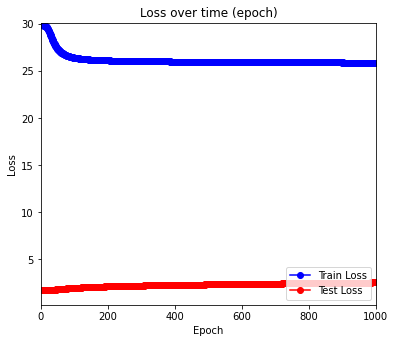

Exec Time : 356.47 seconds

Validation Set
Predictions : torch.Size([2926])
2926 vs 2926
Multi Class Evaluation

Class false Evaluation
- Precision : 32.014 %
- Recall : 16.007 %
- F1 : 0.21343

Class half-true Evaluation
- Precision : 21.216 %
- Recall : 89.718 %
- F1 : 0.34317

Class mostly-true Evaluation
- Precision : 25.275 %
- Recall : 4.035 %
- F1 : 0.06959

Class true Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Class barely-true Evaluation
- Precision : 42.857 %
- Recall : 0.647 %
- F1 : 0.01274

Class pants-fire Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Combined Evaluation
- Accuracy : 22.42 %
- Precision : 20.227 %
- Recall : 18.401 %
- F1 : 0.19271

- Average Confidence : 100.0 %
Model, Combined,,,,false,,,half-true,,,mostly-true,,,true,,,barely-true,,,pants-fire,,,
LiarPantsFire-Multi_4LayerNet_RoBERTa_Finetuned_with_TopTermsVectors Validation, 22.42, 20.227, 18.401, 0.19271, 32.014, 16.007, 0.21343, 21.216, 89.718, 0.34317, 25.275, 4.035, 0.06959,

In [12]:
print("Multiclass Classification using 4-Layer Linear Network")
binary = False

start = time.time()
model_name = f"{dataset_name}_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=6, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                binary=binary,
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in val_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=binary,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in test_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=binary,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)